## BSA fitting using bins in Phi

The purpose of this file is to do BSA fitting for RGA data selected for Exclusive Rho using bins in phi instead of a MLM fit

$$\frac{d\sigma_+-d\sigma_-}{d\sigma_+ + d\sigma_- }  = \alpha \sin \phi$$
where 
$$ \alpha = \frac{\sqrt{2\epsilon (1-\epsilon)}F_{LU}^{\sin \phi}}{F_{UU}} $$

In [1]:
import ROOT
import os
import numpy as np
import uproot

In [4]:
inputFiles = ["out/pippi0_fall2018_in_pass1/pippi0_fall2018_in_pass1.root"]

In [5]:

# Initialize empty lists to collect data
all_phi = []
all_z = []
all_hel = []
all_Mx = []
all_Mdiphoton = []
all_eps = []


for f in inputFiles:
    file = uproot.open(f)
    tree = file["pippi0"]
    branches = tree.arrays(["phi", "z", "hel", "Mx", "Mdiphoton", "eps"], library="np")
    all_phi.append(branches["phi"])
    all_z.append(branches["z"])
    all_hel.append(branches["hel"])
    all_Mx.append(branches["Mx"])
    all_Mdiphoton.append(branches["Mdiphoton"])
    all_eps.append(branches["eps"])


phi_vals = np.concatenate(all_phi)
z_vals = np.concatenate(all_z)
hel_vals = np.concatenate(all_hel)
Mx_vals = np.concatenate(all_Mx)
Mdiphoton_vals = np.concatenate(all_Mdiphoton)
eps_vals = np.concatenate(all_eps)


In [6]:
mask = (
    (branches["Mdiphoton"] > 0.115) & (branches["Mdiphoton"] < 0.16) &
    (branches["Mx"] > 0.85) & (branches["Mx"] < 1.05)
)

phi_vals = branches["phi"][mask]
z_vals = branches["z"][mask]
hel_vals = branches["hel"][mask]
eps_vals = branches["eps"][mask]


In [7]:
print(len(phi_vals))

182


In [8]:
fit = ROOT.TF1("fit","[0]*sin(x)",-3.14,3.14) #"name","fit_type",min,max
fit.SetLineWidth(4)
fit.SetLineColor(ROOT.kBlue)
fit.SetLineStyle(2)

In [9]:
def RunPlotting(A_vals,bin_centers,
                leg_title, graph_title,
                obs_str):
    c = ROOT.TCanvas()
    c.SetTickx()
    c.SetTicky()
    c.SetGridx()
    c.SetGridy()
    
    x = np.array(bin_centers, dtype='float64')
    y = np.array(A_vals, dtype='float64')
    x_errs = np.zeros_like(x)
    y_errs = np.zeros_like(y)

    
    gr = ROOT.TGraphErrors(len(x),x,y,x_errs,y_errs)
    
    gr.SetMarkerColor(ROOT.kBlack)
    gr.SetMarkerStyle(20)
    gr.SetTitle(graph_title)
    gr.GetXaxis().SetTitle(obs_str)
    gr.GetYaxis().SetTitle("F_{LU}^{sin#phi}/F_{UU}")
    gr.GetYaxis().SetRangeUser(-0.3, max(y) * 1.2)
    
    leg = ROOT.TLegend(0.55,0.75,0.85,0.85) #xmin,ymin,xmax.ymax
    leg.AddEntry(gr,leg_title,"p") #name of object being referred, "title shown", (fit line or point)
    leg.SetBorderSize(1)
    
    gr.Draw("AP")
    leg.Draw()
    c.SaveAs("out/test/phi_test3.png")
    
    return

In [10]:
def fitToSin(h_neg,h_pos,zbnmin,zbnmax):
    num = h_pos.Clone("num")  
    
    
    num.Add(h_neg, -1)         # Asym = h_pos - h_neg
    
    denom = h_pos.Clone("denom")
    denom.Add(h_neg)      # denominator = h_neg + h_pos
    
    A.Divide(num,denom)    # Asym = (h_neg - h_pos) / (h_neg + h_pos)

    fit = ROOT.TF1("fit","[0]*sin(x)",zbnmin,zbnmax) 
    
    A.Fit("fit","R")

    c = ROOT.TCanvas()
    A.Draw()
    fit.Draw("same")
    c.Draw()

    print("ch2/ndf:",fit.GetChisquare()/fit.GetNDF())
    return c,fit.GetParameter(0)

phi_bin: 0
phi_neg: 0
phi_pos: 0
h_neg: 0.0
h_pos: 0.0


ZeroDivisionError: float division by zero

Warning in <Fit>: Fit data is empty 


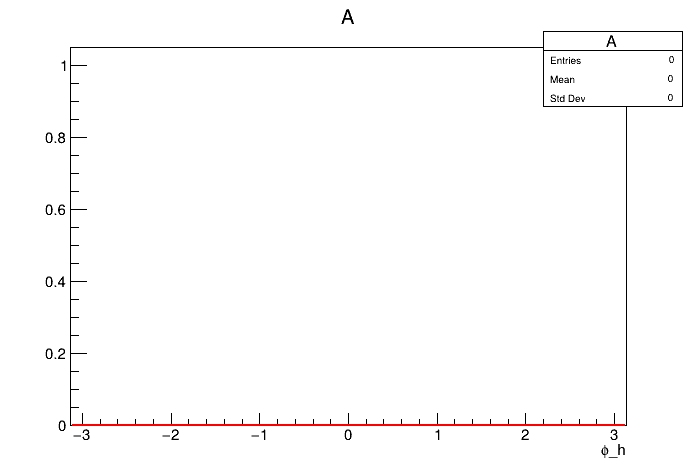

In [11]:
zbn_edges = np.linspace(0.5,1,11)
phibn_edges = np.linspace(-3.14,3.14,50)
ratio_list = []
zbn_centers = []
phibn_centers = []

A = ROOT.TH1F("A","A;#phi_h",100,-3.14,3.14)

for i in range(len(zbn_edges) - 1):
    zmin, zmax = zbn_edges[i], zbn_edges[i+1]
    zbin_mask = (z_vals > zmin) & (z_vals < zmax)

    phi_binned = phi_vals[zbin_mask]
    hel_binned = hel_vals[zbin_mask]
    eps_binned = eps_vals[zbin_mask]

    print(f"phi_bin: {len(phi_binned)}")
    
    # Separate by helicity
    phi_neg = phi_bin[hel_bin == -1]
    phi_pos = phi_bin[hel_bin == 1]

    print(f"phi_neg: {len(phi_neg)}")
    print(f"phi_pos: {len(phi_pos)}")

    # Fill histograms
    h_neg = ROOT.TH1F("h_neg", "h_neg;#phi_h", 100, -3.14, 3.14)
    h_pos = ROOT.TH1F("h_pos", "h_pos;#phi_h", 100, -3.14, 3.14)
    for val in phi_neg:
        h_neg.Fill(val)
    for val in phi_pos:
        h_pos.Fill(val)

    print(f"h_neg: {h_neg.GetEntries()}")
    print(f"h_pos: {h_pos.GetEntries()}")
    
    h_neg.Sumw2()
    h_pos.Sumw2()

    # Fit and calculate asymmetry
    c, A_val = fitToSin(h_neg, h_pos, -3.14, 3.14)

    eps_avg = np.mean(eps_bin)
    depolarization = np.sqrt(2 * eps_avg * (1 - eps_avg))
    ratio_list.append(A_val / depolarization)
    zbn_centers.append((zmin + zmax) / 2)

    

In [ ]:
RunPlotting(ratio_list,zbn_centers,
                "RGA_inbending", "F_{LU}^{sin#phi}/F_{UU}",
                "z")

In [ ]:
print(len(zbn_centers),len(ratio_list))